In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import odeint
from pylab import grid
eps = np.finfo(float).eps
import copy
import time

# Continuously stirred tank reactor (CSTR)

## Dynamic model

In [44]:
def cstr(x, t, Tc, Fin):
    """
    Continuous Stirred-Tank Reactor (CSTR) model.

    Parameters:
    x   : array-like, [Ca, Cb, Cc, T, V] - State variables
    t   : float - Time (not used in this model)
    Tc  : float - Temperature of Cooling Jacket (K)
    Fin : float - Volumetric Flowrate at inlet (m^3/sec)

    Returns:
    xdot: array-like - Derivatives of state variables
    """
    # States
    Ca, Cb, Cc, T, V = x

    # Process parameters
    Tf, Caf, Fout, rho, Cp, UA = 350, 1, 100, 1000, 0.239, 5e4
    mdelH_AB, EoverR_AB, k0_AB = 5e4, 8750, 7.2e10
    mdelH_BC, EoverR_BC, k0_BC = 5e4, 10750, 8.2e10

    # Reaction rates
    rA = k0_AB * np.exp(-EoverR_AB / T) * Ca
    rB = k0_BC * np.exp(-EoverR_BC / T) * Cb

    # Derivatives
    dCadt = (Fin * Caf - Fout * Ca) / V - rA
    dCbdt = rA - rB - Fout * Cb / V
    dCcdt = rB - Fout * Cc / V
    dTdt = (Fin / V * (Tf - T) + mdelH_AB / (rho * Cp) * rA + mdelH_BC / (rho * Cp) * rB + UA / V / rho / Cp * (Tc - T))
    dVdt = Fin - Fout

    # Return derivatives
    return np.array([dCadt, dCbdt, dCcdt, dTdt, dVdt])

## Plot Routines

In [45]:
def plot_convergence(Xdata, best_Y, Objfunc=None):
    """
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    """
    ## if f values are not given
    f_best = 1e8
    if best_Y == None:
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point, :])
            if f_point < f_best:
                f_best = f_point
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n, :] - Xdata[0 : n - 1, :]) ** 2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n - 1)), distances, "-ro")
    plt.xlabel("Iteration")
    plt.ylabel("d(x[n], x[n-1])")
    plt.title("Distance between consecutive x's")
    grid(True)

    # Estimated m(x) at the proposed sampling points
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y, "-o")
    plt.title("Value of the best selected sample")
    plt.xlabel("Iteration")
    plt.ylabel("Best y")
    # plt.yscale("log")
    grid(True)
    plt.show()

In [46]:
def plot_result_ct(Ks, data_plot, repetitions):
    # Load data
    Ca, V, Cb, Tc, Cc, Fin, T, t_c = (copy.deepcopy(data_plot[key]) for key in ["Ca_ct", "V_ct", "Cb_ct", "Tc_ct", "Cc_ct", "Fin_ct", "T_ct", "t_c"])
    Cb_des, T_des = data_plot["Cb_des"], data_plot["T_des"]
    Tc_ub, Tc_lb, Fin_ub, Fin_lb = data_plot["Tc_ub"], data_plot["Tc_lb"], data_plot["Fin_ub"], data_plot["Fin_lb"]
    x0, noise = copy.deepcopy(data_plot["x0"]), data_plot["noise"]
    # setpoints
    Cb_des = data_plot["Cb_des"]
    T_des = data_plot["T_des"]
    # upper and lower bounds
    Tc_ub = data_plot["Tc_ub"]
    Tc_lb = data_plot["Tc_lb"]
    Fin_ub = data_plot["Fin_ub"]
    Fin_lb = data_plot["Fin_lb"]

    # creating lists
    Ca_dat = np.zeros((len(t_c), repetitions))
    Fin_dat = np.zeros((len(t_c) - 1, repetitions))
    Cb_dat = np.zeros((len(t_c), repetitions))
    Tc_dat = np.zeros((len(t_c) - 1, repetitions))
    Cc_dat = np.zeros((len(t_c), repetitions))
    error_dat = np.zeros((len(t_c) - 1, repetitions))
    V_dat = np.zeros((len(t_c), repetitions))
    u_mag_dat = np.zeros((len(t_c) - 1, repetitions))
    T_dat = np.zeros((len(t_c), repetitions))
    u_cha_dat = np.zeros((len(t_c) - 2, repetitions))

    # multiple runs
    for rep_i in range(repetitions):
        # re-loading data
        Ca, V, Cb, Cc, T, t_c, x0 = (copy.deepcopy(data_plot[key]) for key in ["Ca_ct", "V_ct", "Cb_ct", "Cc_ct",  "T_ct", "t_c","x0"])

        # initiate
        x = x0
        e_history = []

        # main process simulation loop
        for i in range(len(t_c) - 1):
            # delta t
            ts = [t_c[i], t_c[i + 1]]
            # desired setpoint
            x_sp = np.array([x0[0], Cb_des[i], x0[2], T_des[i], x0[4]])
            # compute control
            if i == 0:
                Tc[i], Fin[i] = PID(
                    Ks, x0, x_sp, np.array([[x0[0], Tc_lb, x0[2], Fin_lb, x0[4]]])
                )
            else:
                Tc[i], Fin[i] = PID(Ks, x0, x_sp, np.array(e_history))
            # simulate reactor
            y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
            # adding stochastic behaviour
            s = np.random.normal(0, 0.5, size=5)
            Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.01 * noise), 0])
            Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.01 * noise), 0])
            Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.01 * noise), 0])
            T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.01 * noise), 0])
            V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.01 * noise), 0])
            # state update
            x[0] = Ca[i + 1]
            x[1] = Cb[i + 1]
            x[2] = Cc[i + 1]
            x[3] = T[i + 1]
            x[4] = V[i + 1]
            # compute tracking error
            e_history.append((x_sp - x))

        # == objective == #
        # production
        error = np.abs(
            np.array(e_history)[:, 0]
        )  # +np.abs(np.array(e_history)[:,1])/10
        error = error
        # penalize magnitud of control action
        u_mag = (Tc - Tc_lb) / (12) + (Fin - Fin_lb) / (8)
        u_mag = u_mag / 50
        # penalize change in control action
        # u_cha = np.abs(Tc[1:]-Tc[0:-1])/(12) + np.abs(Fin[1:]-Fin[0:-1])/(8)
        u_cha = (Tc[1:] - Tc[0:-1]) ** 2 / (12) ** 2 + (Fin[1:] - Fin[0:-1]) ** 2 / (
            8
        ) ** 2
        u_cha = u_cha / 50

        # data collection
        Ca_dat[:, rep_i] = copy.deepcopy(Ca)
        Fin_dat[:, rep_i] = copy.deepcopy(Fin)
        Cb_dat[:, rep_i] = copy.deepcopy(Cb)
        Tc_dat[:, rep_i] = copy.deepcopy(Tc)
        Cc_dat[:, rep_i] = copy.deepcopy(Cc)
        error_dat[:, rep_i] = copy.deepcopy(error)
        V_dat[:, rep_i] = copy.deepcopy(V)
        u_mag_dat[:, rep_i] = copy.deepcopy(u_mag)
        T_dat[:, rep_i] = copy.deepcopy(T)
        u_cha_dat[:, rep_i] = copy.deepcopy(u_cha)

    # Plot the results
    plt.figure(figsize=(14, 5))

    plt.subplot(2, 4, 1)
    plt.plot(t_c, np.median(Ca_dat, axis=1), "r-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(Ca_dat, axis=1), np.max(Ca_dat, axis=1), color="r", alpha=0.2
    )
    plt.ylabel("A (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of A in CSTR"], loc="best")

    plt.subplot(2, 4, 2)
    plt.plot(t_c, np.median(Cb_dat, axis=1), "g-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(Cb_dat, axis=1), np.max(Cb_dat, axis=1), color="g", alpha=0.2
    )
    plt.plot(t_c, Cb_des, "--", lw=2)
    plt.ylabel("B (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of B in CSTR"], loc="best")  # Cb_des

    plt.subplot(2, 4, 3)
    plt.plot(t_c, np.median(Cc_dat, axis=1), lw=3)
    plt.gca().fill_between(
        t_c, np.min(Cc_dat, axis=1), np.max(Cc_dat, axis=1), alpha=0.2
    )
    plt.ylabel("C (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of C in CSTR"], loc="best")

    plt.subplot(2, 4, 4)
    plt.plot(t_c, np.median(T_dat, axis=1), "c-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(T_dat, axis=1), np.max(T_dat, axis=1), color="c", alpha=0.2
    )
    plt.ylabel("T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Temperature"], loc="best")

    plt.subplot(2, 4, 5)
    plt.plot(t_c, np.median(V_dat, axis=1), "m-", lw=3)
    plt.gca().fill_between(
        t_c, np.min(V_dat, axis=1), np.max(V_dat, axis=1), color="m", alpha=0.2
    )
    plt.ylabel("V (m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Volume"], loc="best")

    plt.subplot(2, 4, 6)
    plt.step(t_c[1:], np.median(Tc_dat, axis=1), "b--", lw=3)
    plt.ylabel("Cooling T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Jacket Temperature"], loc="best")

    plt.subplot(2, 4, 7)
    plt.step(t_c[1:], np.median(Fin_dat, axis=1), "k--", lw=3)
    plt.ylabel("F (m^3/sec)")
    plt.xlabel("Time (min)")
    plt.legend(["Inflow Rate"], loc="best")

    plt.subplot(2, 4, 8)
    plt.plot(t_c[1:], np.median(error_dat, axis=1), "-", lw=3, label="error")
    plt.gca().fill_between(
        t_c[1:], np.min(error_dat, axis=1), np.max(error_dat, axis=1), alpha=0.2
    )
    # plt.plot(t_c[1:],     np.median(u_mag_dat,axis=1), '--', lw=3, label='u_mag')
    # plt.gca().fill_between(t_c[1:], np.min(u_mag_dat,axis=1), np.max(u_mag_dat,axis=1),
    #                       alpha=0.2)
    plt.plot(t_c[2:], np.median(u_cha_dat, axis=1), ".-", lw=3, label="u_cha")
    plt.gca().fill_between(
        t_c[2:], np.min(u_cha_dat, axis=1), np.max(u_cha_dat, axis=1), alpha=0.2
    )
    plt.ylabel("obj function")
    plt.xlabel("Time (min)")
    plt.legend()

    plt.show()

    # print results
    errorsum = np.sum(np.median(error_dat, axis=1))
    u_magsum = np.sum(np.median(u_mag_dat, axis=1))
    u_chasum = np.sum(np.median(u_cha_dat, axis=1))
    print("best result = ", errorsum + u_magsum + u_chasum)

In [47]:
def plot_result(u_opt, data_plot, repetitions):
    # loading process operations
    Ca = copy.deepcopy(data_plot["Ca_dat"])
    V = copy.deepcopy(data_plot["V_dat"])
    Cb = copy.deepcopy(data_plot["Cb_dat"])
    x0 = copy.deepcopy(data_plot["x0"])
    Cc = copy.deepcopy(data_plot["Cc_dat"])
    t = copy.deepcopy(data_plot["t"])
    T = copy.deepcopy(data_plot["T_dat"])
    noise = data_plot["noise"]
    n = copy.deepcopy(data_plot["n"])

    # control preparation
    u_opt = np.array(u_opt)
    u_opt = u_opt.reshape(2, n - 1, order="C")
    Tc = u_opt[0, :]
    Fin = u_opt[1, :]
    # creating lists
    Ca_dat = np.zeros((len(t), repetitions))
    Fin_dat = np.zeros((len(t) - 1, repetitions))
    Cb_dat = np.zeros((len(t), repetitions))
    Tc_dat = np.zeros((len(t) - 1, repetitions))
    Cc_dat = np.zeros((len(t), repetitions))
    prod_dat = np.zeros((len(t), repetitions))
    V_dat = np.zeros((len(t), repetitions))
    u_mag_dat = np.zeros((len(t) - 1, repetitions))
    T_dat = np.zeros((len(t), repetitions))
    u_cha_dat = np.zeros((len(t) - 2, repetitions))

    # multiple repetitions
    for rep_i in range(repetitions):
        # re-loading data
        Ca = copy.deepcopy(data_plot["Ca_dat"])
        V = copy.deepcopy(data_plot["V_dat"])
        Cb = copy.deepcopy(data_plot["Cb_dat"])
        Cc = copy.deepcopy(data_plot["Cc_dat"])
        T = copy.deepcopy(data_plot["T_dat"])
        t = copy.deepcopy(data_plot["t"])
        x0 = copy.deepcopy(data_plot["x0"])
        x = x0

        # main process simulation loop
        for i in range(len(t) - 1):
            ts = [t[i], t[i + 1]]
            y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
            # adding stochastic behaviour
            s = np.random.normal(0, 0.5, size=5)
            Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.01 * noise), 0])
            Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.01 * noise), 0])
            Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.01 * noise), 0])
            T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.01 * noise), 0])
            V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.01 * noise), 0])
            # state update
            x[0] = Ca[i + 1]
            x[1] = Cb[i + 1]
            x[2] = Cc[i + 1]
            x[3] = T[i + 1]
            x[4] = V[i + 1]

        # production yield
        prod = Cb * V - Cc * V
        # penalize magnitud of control action
        u_mag = np.abs(u_opt[0, :] - 295) / 10 + np.abs(u_opt[1, :] - 97) / 5
        # penalize change in control action
        u_cha = (
            np.abs(u_opt[0, 1:] - u_opt[0, 0:-1]) / 10
            + 2 * np.abs(u_opt[1, 1:] - u_opt[1, 0:-1]) / 5
        )

        # data collection
        Ca_dat[:, rep_i] = copy.deepcopy(Ca)
        Fin_dat[:, rep_i] = copy.deepcopy(Fin)
        Cb_dat[:, rep_i] = copy.deepcopy(Cb)
        Tc_dat[:, rep_i] = copy.deepcopy(Tc)
        Cc_dat[:, rep_i] = copy.deepcopy(Cc)
        prod_dat[:, rep_i] = copy.deepcopy(prod)
        V_dat[:, rep_i] = copy.deepcopy(V)
        u_mag_dat[:, rep_i] = copy.deepcopy(u_mag)
        T_dat[:, rep_i] = copy.deepcopy(T)
        u_cha_dat[:, rep_i] = copy.deepcopy(u_cha)

    # Plot the results
    plt.figure(figsize=(14, 5))

    plt.subplot(2, 4, 1)
    plt.plot(t, np.median(Ca_dat, axis=1), "r-", lw=3)
    plt.gca().fill_between(
        t, np.min(Ca_dat, axis=1), np.max(Ca_dat, axis=1), color="r", alpha=0.2
    )
    plt.ylabel("A (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of A in CSTR"], loc="best")

    plt.subplot(2, 4, 2)
    plt.plot(t, np.median(Cb_dat, axis=1), "g-", lw=3)
    plt.gca().fill_between(
        t, np.min(Cb_dat, axis=1), np.max(Cb_dat, axis=1), color="g", alpha=0.2
    )
    plt.ylabel("B (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of B in CSTR"], loc="best")

    plt.subplot(2, 4, 3)
    plt.plot(t, np.median(Cc_dat, axis=1), lw=3)
    plt.gca().fill_between(t, np.min(Cc_dat, axis=1), np.max(Cc_dat, axis=1), alpha=0.2)
    plt.ylabel("C (mol/m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Concentration of C in CSTR"], loc="best")

    plt.subplot(2, 4, 4)
    plt.plot(t, np.median(T_dat, axis=1), "c-", lw=3)
    plt.gca().fill_between(
        t, np.min(T_dat, axis=1), np.max(T_dat, axis=1), color="c", alpha=0.2
    )
    plt.ylabel("T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Temperature"], loc="best")

    plt.subplot(2, 4, 5)
    plt.plot(t, np.median(V_dat, axis=1), "m-", lw=3)
    plt.gca().fill_between(
        t, np.min(V_dat, axis=1), np.max(V_dat, axis=1), color="m", alpha=0.2
    )
    plt.ylabel("V (m^3)")
    plt.xlabel("Time (min)")
    plt.legend(["Reactor Volume"], loc="best")

    plt.subplot(2, 4, 6)
    plt.step(t[1:], np.median(Tc_dat, axis=1), "b--", lw=3)
    plt.ylabel("Cooling T (K)")
    plt.xlabel("Time (min)")
    plt.legend(["Jacket Temperature"], loc="best")

    plt.subplot(2, 4, 7)
    plt.step(t[1:], np.median(Fin_dat, axis=1), "k--", lw=3)
    plt.ylabel("F (m^3/sec)")
    plt.xlabel("Time (min)")
    plt.legend(["Inflow Rate"], loc="best")

    plt.subplot(2, 4, 8)
    plt.plot(t, np.median(prod_dat, axis=1), "-", lw=3, label="prod")
    plt.gca().fill_between(
        t, np.min(prod_dat, axis=1), np.max(prod_dat, axis=1), alpha=0.2
    )
    plt.plot(t[1:], np.median(u_mag_dat, axis=1) * 10, "--", lw=3, label="u_mag")
    plt.gca().fill_between(
        t[1:], np.min(u_mag_dat, axis=1), np.max(u_mag_dat, axis=1), alpha=0.2
    )
    plt.plot(t[2:], np.median(u_cha_dat, axis=1) * 10, ".-", lw=3, label="u_cha")
    plt.gca().fill_between(
        t[2:], np.min(u_cha_dat, axis=1), np.max(u_cha_dat, axis=1), alpha=0.2
    )
    plt.ylabel("obj function")
    plt.xlabel("Time (min)")
    plt.legend()

    plt.show()

    # print results
    prodsum = np.sum(np.median(prod_dat, axis=1))
    u_magsum = np.sum(np.median(u_mag_dat, axis=1))
    u_chasum = np.sum(np.median(u_cha_dat, axis=1))
    print("best result = ", -prodsum + u_magsum * 10 + u_chasum * 10)

## CSTR Simulation

In [48]:
#####################
# process operation #
#####################

data_res = {}
# Initial conditions for the states
x0 = np.zeros(5)
x0[0] = 0.87725294608097  # Initial concentration of A in CSTR (mol/m^3)
x0[1] = 0.0  # Initial concentration of B in CSTR (mol/m^3)
x0[2] = 0.0  # Initial concentration of C in CSTR (mol/m^3)
x0[3] = 324.475443431599  # Initial temperature in CSTR (K)
x0[4] = 100  # Initial volume in CSTR (m^3)
data_res["x0"] = x0

# Time interval (min)
n = 11  # number of intervals
Tf = 25  # process time (min)
t = np.linspace(0, Tf, n)
data_res["t"] = t
data_res["n"] = n

# Store results for plotting
Ca = np.zeros(len(t))
Ca[0] = x0[0]
Cb = np.zeros(len(t))
Cb[0] = x0[1]
Cc = np.zeros(len(t))
Cc[0] = x0[2]
T = np.zeros(len(t))
T[0] = x0[3]
V = np.zeros(len(t))
V[0] = x0[4]
Tc = np.zeros(len(t) - 1)
Fin = np.zeros(len(t) - 1)
data_res["Ca_dat"] = copy.deepcopy(Ca)
data_res["V_dat"] = copy.deepcopy(V)
data_res["Cb_dat"] = copy.deepcopy(Cb)
data_res["Tc_dat"] = copy.deepcopy(Tc)
data_res["Cc_dat"] = copy.deepcopy(Cc)
data_res["Fin_dat"] = copy.deepcopy(Fin)
data_res["T_dat"] = copy.deepcopy(T)
# noise level
noise = 0  # [0,0.1,1]
data_res["noise"] = noise

# control upper and lower bounds
data_res["Tc_ub"] = 302
data_res["Tc_lb"] = 290
data_res["Fin_ub"] = 105
data_res["Fin_lb"] = 97
Tc_ub = data_res["Tc_ub"]
Tc_lb = data_res["Tc_lb"]
Fin_ub = data_res["Fin_ub"]
Fin_lb = data_res["Fin_lb"]

In [49]:
Tc = np.zeros(len(t) - 1)
Fin = np.zeros(len(t) - 1)
# Step cooling temperature to (295 - 302)
Tc[0:2] = 302.0
Tc[2:4] = 295.0
Tc[4:7] = 300.0
Tc[7:] = 298.0

# Step for volumetric flowrate at inlet (97,102)
Fin[0:3] = 100
Fin[3:6] = 97
Fin[6:8] = 99
Fin[8:] = 102

u_ = np.hstack((Tc, Fin))
# # simulate process
# plot_result(u_, data_res, 20)

## Constant volume CSTR

This system has the same input and output flow for there to be a steady state.

In [50]:
###############################
#  CSTR constant volume model #
###############################


def cstr_ss(x, t, u1, u2):
    # ==  Inputs (2) == #
    Tc = u1  # Temperature of Cooling Jacket (K)
    Fin = u2  # Volumetric Flowrate at inlet (m^3/sec) = 100

    # == States (5) == #
    Ca = x[0]  # Concentration of A in CSTR (mol/m^3)
    Cb = x[1]  # Concentration of B in CSTR (mol/m^3)
    Cc = x[2]  # Concentration of C in CSTR (mol/m^3)
    T = x[3]  # Temperature in CSTR (K)
    V = x[4]  # Volume in CSTR (K)

    # == Process parameters == #
    Tf = 350  # Feed Temperature (K)
    Caf = 1  # Feed Concentration of A (mol/m^3)
    Fout = Fin  # Volumetric Flowrate at outlet (m^3/sec)
    # V       = 100    # Volume of CSTR (m^3)
    rho = 1000  # Density of A-B Mixture (kg/m^3)
    Cp = 0.239  # Heat Capacity of A-B-C Mixture (J/kg-K)
    UA = 5e4  # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    # Reaction A->B
    mdelH_AB = 5e4  # Heat of Reaction for A->B (J/mol)
    EoverR_AB = 8750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0_AB = 7.2e10  # Pre-exponential Factor for A->B (1/sec)#
    rA = k0_AB * np.exp(-EoverR_AB / T) * Ca  # reaction rate
    # Reaction B->C
    mdelH_BC = 5e4  # Heat of Reaction for B->C (J/mol) => 5e4
    EoverR_BC = (
        10750  # E -Activation Energy (J/mol), R -Constant = 8.31451 J/mol-K !! 10
    )
    k0_BC = 8.2e10  # Pre-exponential Factor for A->B (1/sec)# !! 8
    rB = k0_BC * np.exp(-EoverR_BC / T) * Cb  # reaction rate !! **2
    # play with mdelH_BC, factor on Cb**2 and k0_BC, maybe even EoverR_BC

    # == Concentration Derivatives == #
    dCadt = (Fin * Caf - Fout * Ca) / V - rA  # A Concentration Derivative
    dCbdt = rA - rB - Fout * Cb / V  # B Concentration Derivative
    dCcdt = rB - Fout * Cc / V  # B Concentration Derivative
    dTdt = (
        Fin / V * (Tf - T)
        + mdelH_AB / (rho * Cp) * rA
        + mdelH_BC / (rho * Cp) * rB
        + UA / V / rho / Cp * (Tc - T)
    )  # Calculate temperature derivative
    dVdt = 0

    # == Return xdot == #
    xdot = np.zeros(5)
    xdot[0] = dCadt
    xdot[1] = dCbdt
    xdot[2] = dCcdt
    xdot[3] = dTdt
    xdot[4] = dVdt
    return xdot

## Powell

In [51]:
#########################
# --- Random search --- #
#########################

# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float
def Random_search(f, n_p, bounds_rs, iter_rs):
    """
    This function is a naive optimization routine that randomly samples the
    allowed space and returns the best value.

    This is used to find a good starting point for Powell
    """

    # arrays to store sampled points
    localx = np.zeros((n_p, iter_rs))  # points sampled
    localval = np.zeros((iter_rs))  # function values sampled
    # bounds
    bounds_range = bounds_rs[:, 1] - bounds_rs[:, 0]
    bounds_bias = bounds_rs[:, 0]

    for sample_i in range(iter_rs):
        x_trial = np.random.uniform(0, 1, n_p) * bounds_range + bounds_bias  # sampling
        localx[:, sample_i] = x_trial
        localval[sample_i] = f(x_trial)  # f
    # choosing the best
    minindex = np.argmin(localval)
    f_b = localval[minindex]
    x_b = localx[:, minindex]

    return f_b, x_b


#########################
# --- Powell Method --- #
#########################


# (f, N_x: int, bounds: array[array[float]], N: int = 100) -> array(N_X), float
def opt_Powell(f, x_dim, bounds, iter_tot):
    """
    params: parameters that define the rbf model
    X:      matrix of previous datapoints
    """

    n_rs = int(
        min(100, max(iter_tot * 0.05, 5))
    )  # iterations to find good starting point

    # evaluate first point
    f_best, x_best = Random_search(f, x_dim, bounds, n_rs)
    iter_ = iter_tot - n_rs

    opt = minimize(f, x_best, bounds=bounds, method="Powell", options={"maxfev": iter_})

    print("-- optimization results -- ")
    print(opt)

    return opt.x, opt.fun

# Controller Tuning

## Process operation

In [52]:
#############################
# process control operation #
#############################

# Time interval (min)
n_c = 101  # 41#21 # 11
Tf_c = 30  # 30 # process time (min) 25
t_c = np.linspace(0, Tf_c, n_c)
data_res["t_c"] = t_c

# desired setpoints
n_1 = int(n_c / 2)
n_2 = n_c - n_1
Cb_des = [0.2 for i in range(n_1)] + [0.2 for i in range(n_2)]
T_des = [330 for i in range(n_1)] + [325 for i in range(n_2)]
data_res["Cb_des"] = Cb_des
data_res["T_des"] = T_des

# Store results for plotting
Ca = np.zeros(len(t_c))
Ca[0] = copy.deepcopy(x0[0])
Cb = np.zeros(len(t_c))
Cb[0] = copy.deepcopy(x0[1])
Cc = np.zeros(len(t_c))
Cc[0] = copy.deepcopy(x0[2])
T = np.zeros(len(t_c))
T[0] = copy.deepcopy(x0[3])
V = np.zeros(len(t_c))
V[0] = copy.deepcopy(x0[4])
Tc = np.zeros(len(t_c) - 1)
Fin = np.zeros(len(t_c) - 1)
data_res["Ca_ct"] = copy.deepcopy(Ca)
data_res["V_ct"] = copy.deepcopy(V)
data_res["Cb_ct"] = copy.deepcopy(Cb)
data_res["Tc_ct"] = copy.deepcopy(Tc)
data_res["Cc_ct"] = copy.deepcopy(Cc)
data_res["Fin_ct"] = copy.deepcopy(Fin)
data_res["T_ct"] = copy.deepcopy(T)

## PID controller

In [53]:
##################
# PID controller #
##################


def PID(Ks, x, x_setpoint, e_history):
    Ks = np.array(Ks)
    Ks = Ks.reshape(32, order="C")
    # u_T gains for Ca, Cb, T, V, and bias
    KpCbT = Ks[0]
    KiCbT = Ks[1]
    KdCbT = Ks[2]
    KpTT = Ks[3]
    KiTT = Ks[4]
    KdTT = Ks[5]
    KpCaT = Ks[6]
    KiCaT = Ks[7]
    KdCaT = Ks[8]
    KpCcT = Ks[9]
    KiCcT = Ks[10]
    KdCcT = Ks[11]
    KpVT = Ks[12]
    KiVT = Ks[13]
    KdVT = Ks[14]
    KT = Ks[15]
    # u_F K gains for Ca, Cb, T, V, and bias
    KpCbF = Ks[16]
    KiCbF = Ks[17]
    KdCbF = Ks[18]
    KpTF = Ks[19]
    KiTF = Ks[20]
    KdTF = Ks[21]
    KpCaF = Ks[22]
    KiCaF = Ks[23]
    KdCaF = Ks[24]
    KpCcF = Ks[25]
    KiCcF = Ks[26]
    KdCcF = Ks[27]
    KpVF = Ks[28]
    KiVF = Ks[29]
    KdVF = Ks[30]
    KF = Ks[31]

    # setpoint error
    e = x_setpoint - x

    # control action Tc
    u_T = (
        KpCbT * e[1] + KiCbT * sum(e_history[:, 1]) + KdCbT * (e[1] - e_history[-1, 1])
    )
    u_T += KpTT * e[3] + KiTT * sum(e_history[:, 3]) + KdTT * (e[3] - e_history[-1, 3])
    u_T += KpTT * e[0] + KiTT * sum(e_history[:, 0]) + KdTT * (e[0] - e_history[-1, 0])
    u_T += KpTT * e[2] + KiTT * sum(e_history[:, 2]) + KdTT * (e[2] - e_history[-1, 2])
    u_T += KpTT * e[4] + KiTT * sum(e_history[:, 4]) + KdTT * (e[4] - e_history[-1, 4])
    u_T += KT
    u_T = min(max(u_T, Tc_lb), Tc_ub)

    # control action Fin
    u_F = (
        KpCbF * e[0] + KiCbF * sum(e_history[:, 0]) + KdCbF * (e[1] - e_history[-1, 0])
    )
    u_F += KpTF * e[3] + KiTF * sum(e_history[:, 3]) + KdTF * (e[3] - e_history[-1, 3])
    u_F += KpTF * e[0] + KiTF * sum(e_history[:, 0]) + KdTF * (e[0] - e_history[-1, 0])
    u_F += KpTF * e[2] + KiTF * sum(e_history[:, 2]) + KdTF * (e[2] - e_history[-1, 2])
    u_F += KpTF * e[4] + KiTF * sum(e_history[:, 4]) + KdTF * (e[4] - e_history[-1, 4])
    u_F += KF
    u_F = min(max(u_F, Fin_lb), Fin_ub)
    print("UF",u_F)
    return u_T, u_F

## Objective function: control

In [54]:
def J_ControlCSTR(Ks, data_res=data_res, full_output=False):
    # load data
    Ca = copy.deepcopy(data_res["Ca_ct"])
    V = copy.deepcopy(data_res["V_ct"])
    Cb = copy.deepcopy(data_res["Cb_ct"])
    Tc = copy.deepcopy(data_res["Tc_ct"])
    Cc = copy.deepcopy(data_res["Cc_ct"])
    Fin = copy.deepcopy(data_res["Fin_ct"])
    T = copy.deepcopy(data_res["T_ct"])
    t_c = copy.deepcopy(data_res["t_c"])
    x0 = copy.deepcopy(data_res["x0"])
    noise = data_res["noise"]
    # setpoints
    Cb_des = data_res["Cb_des"]
    T_des = data_res["T_des"]
    # upper and lower bounds
    Tc_ub = data_res["Tc_ub"]
    Tc_lb = data_res["Tc_lb"]
    Fin_ub = data_res["Fin_ub"]
    Fin_lb = data_res["Fin_lb"]

    # initiate
    x = x0
    e_history = []
    # main loop
    for i in range(len(t_c) - 1):
        # delta t
        ts = [t_c[i], t_c[i + 1]]
        # desired setpoint
        x_sp = np.array([x0[0], Cb_des[i], x0[2], T_des[i], x0[4]])
        # compute control
        if i == 0:
            Tc[i], Fin[i] = PID(
                Ks, x, x_sp, np.array([[x0[0], Tc_lb, x0[2], Fin_lb, x0[4]]])
            )
        else:
            Tc[i], Fin[i] = PID(Ks, x, x_sp, np.array(e_history))
        # simulate reactor
        y = odeint(cstr, x, ts, args=(Tc[i], Fin[i]))
        # adding stochastic behaviour
        s = np.random.normal(0, 0.5, size=5)
        Ca[i + 1] = max([y[-1][0] * (1 + s[0] * 0.01 * noise), 0])
        Cb[i + 1] = max([y[-1][1] * (1 + s[1] * 0.01 * noise), 0])
        Cc[i + 1] = max([y[-1][2] * (1 + s[2] * 0.01 * noise), 0])
        T[i + 1] = max([y[-1][3] * (1 + s[3] * 0.01 * noise), 0])
        V[i + 1] = max([y[-1][4] * (1 + s[4] * 0.01 * noise), 0])
        # state update
        x[0] = Ca[i + 1]
        x[1] = Cb[i + 1]
        x[2] = Cc[i + 1]
        x[3] = T[i + 1]
        x[4] = V[i + 1]
        # compute tracking error
        e_history.append(x_sp - x)

    # == objective == #
    # production
    error = np.abs(np.array(e_history)[:, 1])  # +np.abs(np.array(e_history)[:,1])/10
    # penalize magnitud of control action
    u_mag = (Tc - Tc_lb) / (12) + (Fin - Fin_lb) / (8)
    u_mag = u_mag / 50
    # penalize change in control action
    # u_cha = np.abs(Tc[1:]-Tc[0:-1])/(12) + np.abs(Fin[1:]-Fin[0:-1])/(8)
    u_cha = (Tc[1:] - Tc[0:-1]) ** 2 / (12) ** 2 + (Fin[1:] - Fin[0:-1]) ** 2 / (8) ** 2
    u_cha = u_cha / 50

    if full_output:
        # == outputs == #
        return t_c, Ca, Cb, Cc, T, V, Tc, Fin, error, u_mag, u_cha
    else:
        # == objective == #
        error = np.sum(error)
        u_mag = np.sum(u_mag)
        u_cha = np.sum(u_cha)
        return error + u_cha  # + u_mag

### Process Control: Powell

In [55]:
iter_tot = 500

boundsK = np.array(
    [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Tc_lb]]
    + [[0.0, 5.0]] * 6
    + [[-2, 2]] * 9
    + [[0.0, Fin_lb]]
)

start_time = time.time()
Kpowell, f_opt = opt_Powell(J_ControlCSTR, int(32), boundsK, iter_tot)
end_time = time.time()

print("this optimization took ", end_time - start_time, " (s)")
print("Ks = ", Kpowell)

[ 3.62477553  4.84241177  1.92719219  3.53138608  2.1047104   1.84619662
 -0.22809152  0.95797686  0.11801322 -0.46677376 -0.916606    1.39244538
  1.99287283 -1.42038661  1.19182501 28.57337765  1.40329287  4.60195607
  4.46764271  2.52542367  1.63294722  4.33316399  0.60507885 -1.89147519
 -0.27579317 -0.39570479  1.52474883  0.40439388 -1.7026811   1.35060568
 -1.20595392 82.54866219]
UF 97
UF 100.34646524130554
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97

UF 97
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 97
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 105
UF 1

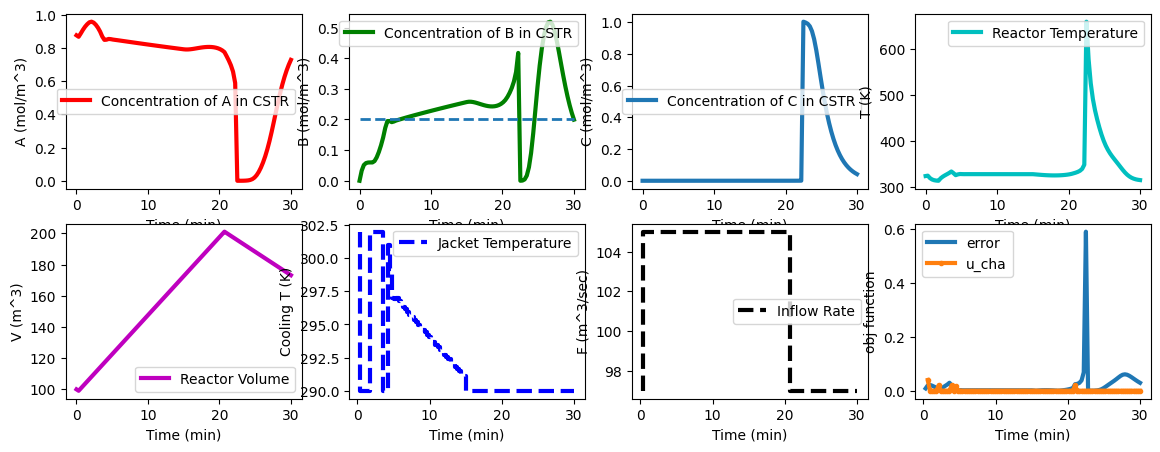

best result =  3.717007580661315


In [56]:
plot_result_ct(Kpowell, data_res, 3)